# LOGISTIC REGRESSION WITH SCIKIT-LEARN
This is an example of logistic regression model in Python with the scikit-learn module, performed with Internet Demographics data set. I have used a more sophisticated version of this approach in designing and building "CAPITALONE RECRUITMENT APPLICATION (CORA)". The APP is CapitalOne's official entry to South By SouthWest conference.

# DATASET
I am using the Internet Demographics data set taken from http://www-stat.wharton.upenn.edu/~waterman/DataSets/uva.txt

# DESCRIPTION OF VARIABLES
The dataset contains 10 variables:

Newbie, Age, Gender, Household.Income, Sexual.Preference, Country, Education.Attainment, Major.Occupation, Marital.Status, Years.on.Internet     
 

# PROBLEM STATEMENT
Try to classify users into the Newbie category; that is those that have been on the Internet for less than a year, based on a set of demographic indicators. I am treating this as a multiple logistic regression problem.

# IMPORT MODULES

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# DATA EXPLORATION

In [15]:
data = pd.read_csv('C:/Users/happy/Documents/Datasets/InternetNewbie.csv')

print(data.head())
print(data.describe())
print(data.shape)

       who  Newbie  Age  Gender Household Income Sexual Preference  \
0  id74364       0   54    Male           $50-74          Gay male   
1  id84505       0   39  Female        Over $100      Heterosexual   
2  id84509       1   49  Female           $40-49      Heterosexual   
3  id87028       1   22  Female           $40-49      Heterosexual   
4  id76087       0   20    Male           $30-39          Bisexual   

      Country Education Attainment Major Occupation Marital Status  \
0     Ontario         Some College         Computer          Other   
1      Sweden         Professional            Other          Other   
2  Washington         Some College       Management          Other   
3     Florida         Some College         Computer        Married   
4  New Jersey         Some College        Education         Single   

  Years on Internet  
0            4-6 yr  
1            1-3 yr  
2        Under 6 mo  
3           6-12 mo  
4            1-3 yr  
             Newbie       

In [23]:
# Number of Newbies in the dataset
print(pd.value_counts(data['Newbie']))

0    11596
1     3836
Name: Newbie, dtype: int64


In [33]:
# Total number of Newbie's and non-Newbie's
data.groupby('Newbie').sum()
#data.groupby('Preference').mean()

data.groupby('Gender').mean()
data.groupby('Income').mean()

,Newbie,Age,Newbie_c
Income,,,
$10-19,0.315559,30.567308,0.315559
$20-29,0.297150,32.847180,0.297150
$30-39,0.280790,34.587316,0.280790
$40-49,0.270070,36.223202,0.270070
$50-74,0.237161,37.745093,0.237161
$75-99,0.184295,38.997329,0.184295
Over $100,0.147764,39.139040,0.147764
Under $10,0.332956,25.377123,0.332956


# DATA PRE-PROCESSING

In [28]:
# Total number of NaN cells
print(data.isnull().sum().sum())

# Drop rows with NaN cells 
data = data.dropna()

0


In [30]:
# Simplify Column names
data = data.rename(columns=lambda x: x.replace('Education Attainment', 'Education'))
data = data.rename(columns=lambda x: x.replace('Sexual Preference', 'Preference'))
data = data.rename(columns=lambda x: x.replace('Household Income', 'Income'))
data = data.rename(columns=lambda x: x.replace('Marital Status', 'MaritalStatus'))

In [32]:
# Add "Newbie_c" column: 1 represents Newbie, 0 represents not
data['Newbie_c'] = (data.Newbie > 0).astype(int)
print(data.head())

       who  Newbie  Age  Gender     Income    Preference     Country  \
0  id74364       0   54    Male     $50-74      Gay male     Ontario   
1  id84505       0   39  Female  Over $100  Heterosexual      Sweden   
2  id84509       1   49  Female     $40-49  Heterosexual  Washington   
3  id87028       1   22  Female     $40-49  Heterosexual     Florida   
4  id76087       0   20    Male     $30-39      Bisexual  New Jersey   

      Education Major Occupation MaritalStatus Years on Internet  Newbie_c  
0  Some College         Computer         Other            4-6 yr         0  
1  Professional            Other         Other            1-3 yr         0  
2  Some College       Management         Other        Under 6 mo         1  
3  Some College         Computer       Married           6-12 mo         1  
4  Some College        Education        Single            1-3 yr         0  


# DATA VISUALIZATION

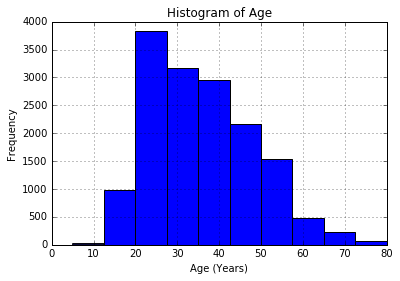

In [36]:
%matplotlib inline
data.Age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age (Years)')
plt.ylabel('Frequency')

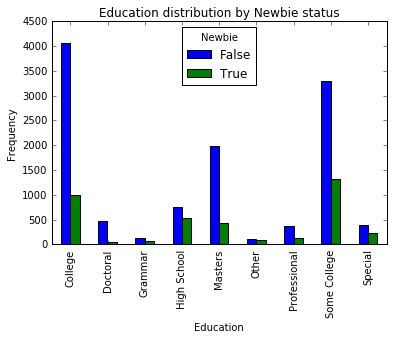

In [37]:
pd.crosstab(data.Education, data.Newbie.astype(bool)).plot(kind='bar')
plt.title('Education distribution by Newbie status')
plt.xlabel('Education')
plt.ylabel('Frequency')


In [38]:
# Convert columns to categories
data["Gender"] = data["Gender"].astype('category')
data["Education"] = data["Education"].astype('category')
data["Preference"] = data["Preference"].astype('category')
data["Income"] = data["Income"].astype('category')
data["MaritalStatus"] = data["MaritalStatus"].astype('category')
print(data.head())


       who  Newbie  Age  Gender     Income    Preference     Country  \
0  id74364       0   54    Male     $50-74      Gay male     Ontario   
1  id84505       0   39  Female  Over $100  Heterosexual      Sweden   
2  id84509       1   49  Female     $40-49  Heterosexual  Washington   
3  id87028       1   22  Female     $40-49  Heterosexual     Florida   
4  id76087       0   20    Male     $30-39      Bisexual  New Jersey   

      Education Major Occupation MaritalStatus Years on Internet  Newbie_c  
0  Some College         Computer         Other            4-6 yr         0  
1  Professional            Other         Other            1-3 yr         0  
2  Some College       Management         Other        Under 6 mo         1  
3  Some College         Computer       Married           6-12 mo         1  
4  Some College        Education        Single            1-3 yr         0  


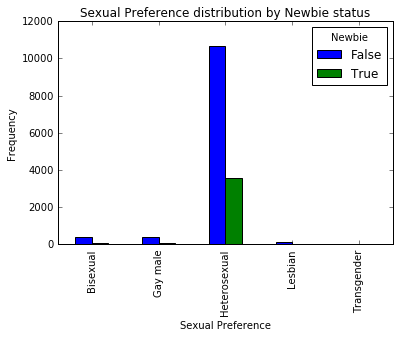

In [39]:
pd.crosstab(data['Preference'], data.Newbie.astype(bool)).plot(kind='bar')
plt.title('Sexual Preference distribution by Newbie status')
plt.xlabel('Sexual Preference')
plt.ylabel('Frequency')


# PREPARE DATA FOR LOGISTIC REGRESSION

In [41]:
# MODEL features
y, X = dmatrices('Newbie_c ~ Age + Gender + Education + Preference + Income + MaritalStatus',
                  data, return_type = "dataframe")
print(X.columns)

Index(['Intercept', 'Gender[T.Male]', 'Education[T.Doctoral]',
       'Education[T.Grammar]', 'Education[T.High School]',
       'Education[T.Masters]', 'Education[T.Other]',
       'Education[T.Professional]', 'Education[T.Some College]',
       'Education[T.Special]', 'Preference[T.Gay male]',
       'Preference[T.Heterosexual]', 'Preference[T.Lesbian]',
       'Preference[T.Transgender]', 'Income[T.$20-29]', 'Income[T.$30-39]',
       'Income[T.$40-49]', 'Income[T.$50-74]', 'Income[T.$75-99]',
       'Income[T.Over $100]', 'Income[T.Under $10]',
       'MaritalStatus[T.Married]', 'MaritalStatus[T.Other]',
       'MaritalStatus[T.Separated]', 'MaritalStatus[T.Single]',
       'MaritalStatus[T.Widowed]', 'Age'],
      dtype='object')


In [42]:
# Flatten response variable y into a 1-D array
y = np.ravel(y)

# INSTANTIATE A LOGISTIC REGRESSION MODEL AND FIT WITH X AND Y

In [43]:
model = LogisticRegression()
model = model.fit(X, y)

In [44]:
# Check the accuracy on the training set
model.score(X, y)

0.75738724727838258

In [45]:
# Percentage of Newbies
y.mean()

0.24857439087610161

In [46]:
# NOTE THAT 24% are Newbies. So we're doing better than the null error rate, but not by much.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model2 = LogisticRegression()
model2.fit(X_train, y_train)
predicted = model2.predict(X_test)

# EVALUATION METRICS

In [51]:
print(metrics.accuracy_score(y_test, predicted))

0.755075593952


In [52]:
# The accuracy is 76%

In [53]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[3332  136]
 [ 998  164]]
             precision    recall  f1-score   support

        0.0       0.77      0.96      0.85      3468
        1.0       0.55      0.14      0.22      1162

avg / total       0.71      0.76      0.70      4630



# MODEL EVALUATION USING CROSS-VALIDATION

In [54]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.75582902  0.75518135  0.76165803  0.74546632  0.75906736  0.75777202
  0.75097276  0.75680934  0.76783398  0.7542153 ]
0.756480548107


In [55]:
# STILL PEERFORMING AT 76% ACCURACY

# PREDICT A NEWBIE INTERNET USER

In [68]:
# model.predict_proba(np.array([DATA HERE]))